# **GIS × Python Tutorial 5.3 ~ 空間検索の為の材料作成 MeshGrid編 ~**

<br>

## **はじめに**
この記事は「GIS × Python Tutorial」の関連記事です。

前回の記事では`geopandas`の空間検索メソッドについて紹介しました。geopandas で空間検索を行う場合、例えばある市町村内にあるコンビニの位置を分析するとして、市町村内をいくつかのブロックに分けたり、あるいはグリッドやH3の様なポリゴンメッシュを使用したくなるかもしれません。今回はそんな空間検索で使用する材料作成に焦点をあてて紹介していきます。

<br>

## **コード実行の準備**

### **Import**

In [2]:
import math
import string
from typing import NamedTuple, List

import geopandas as gpd
import japanize_matplotlib
from matplotlib import pyplot as plt
import numpy as np
import shapely
import shapely.affinity
from shapely.plotting import plot_points
from shapely.plotting import plot_polygon
japanize_matplotlib.japanize()

<br>

## **Mesh Grid の作成**

メッシュグリッドは四角形の集合です。四角形は「左上のXY」「右上のXY」「右下のXY」「左下のXY」の 4つの座標 8つの数値から構成されます。`shapely.box(x_min, y_min, x_max, y_max)`で作成できるので実際は 4つの数値で作成可能です。



## **範囲の調整**
まずは MeshGrid の範囲を計算する関数を作成してみましょう。左上を始点として右方向と下方向に向けて範囲を計算します。解像度を指定するのでほとんどの場合が割切れません。小さくするのは論外なので、大きく範囲を広げる事で対応しましょう。

In [15]:
def adjust_max_cds(min_: float, max_: float, resolution: float) -> float:
    # 剰余を計算する
    _, remainder = divmod(abs(max_ - min_), resolution)
    if 0 < remainder:
        # 剰余が出た場合は範囲を拡大させる
        max_ += resolution - remainder
    return max_


def adjust_min_cds(min_: float, max_: float, resolution: float) -> float:
    # 剰余を計算する
    _, remainder = divmod(abs(max_ - min_), resolution)
    if 0 < remainder:
        # 剰余が出た場合は範囲を拡大させる
        min_ -= resolution - remainder
    return min_



# 範囲を定義する
x_min, x_max = -20, 106
x_resol = 20

y_min, y_max = 14, 111
y_resol = 16

# 範囲を調整する
x_max = adjust_max_cds(x_min, x_max, x_resol)
y_min = adjust_min_cds(y_min, y_max, y_resol)

width = abs(x_max - x_min)
height = abs(y_max - y_min)
print(f"""
x_min: {x_min}, x_max: {x_max}, width: {width}, cells: {width / x_resol}
y_min: {y_min}, y_max: {y_max}, height: {height}, cells: {height / y_resol}
""")


x_min: -20, x_max: 120, width: 140, cells: 7.0
y_min: -1, y_max: 111, height: 112, cells: 7.0



## **MeshGridに使用する左上の座標を計算する**


`numpy.arange(最小座標, 最大座標, 解像度)`で xy 座標の配列を作成してみます。x 座標は左から右へ向かうので`np.arange(x_min, y_min, resolution)`で問題ありませんが、y 座標は上から下へ向かわせたいので`np.arange(y_min, y_max, resolution)[::-1]`として降順にソートします。

In [16]:
xs = np.arange(x_min, x_max + x_resol, x_resol)
ys = np.arange(y_min, y_max + y_resol, y_resol)[::-1]
print(f"xs: {xs}")
print(f"ys: {ys}")

xs: [-20   0  20  40  60  80 100 120]
ys: [111  95  79  63  47  31  15  -1]


numpyには`np.meshgrid`という便利なメソッドが用意されています。x と y それぞれの 1次元配列を渡す事でそれぞれの MeshGrid を形成する 2次元配列で返してくれます。

In [17]:
x_2d, y_2d = np.meshgrid(xs, ys)
print(f"""
x meshgrid: \n{x_2d}\n
y meshgrid: \n{y_2d}\n
""")


x meshgrid: 
[[-20   0  20  40  60  80 100 120]
 [-20   0  20  40  60  80 100 120]
 [-20   0  20  40  60  80 100 120]
 [-20   0  20  40  60  80 100 120]
 [-20   0  20  40  60  80 100 120]
 [-20   0  20  40  60  80 100 120]
 [-20   0  20  40  60  80 100 120]
 [-20   0  20  40  60  80 100 120]]

y meshgrid: 
[[111 111 111 111 111 111 111 111]
 [ 95  95  95  95  95  95  95  95]
 [ 79  79  79  79  79  79  79  79]
 [ 63  63  63  63  63  63  63  63]
 [ 47  47  47  47  47  47  47  47]
 [ 31  31  31  31  31  31  31  31]
 [ 15  15  15  15  15  15  15  15]
 [ -1  -1  -1  -1  -1  -1  -1  -1]]




## **MeshGridを構成する四隅の座標を作成する**

2次元配列からスライスして値を取り出し、各 Polygon を構成する四隅の座標を作成します。作成したら計算をわかりやすくする為に 1次元配列に変換してしまいましょう。

In [18]:
# わかりやすい様にNamedTupleのクラスを作成しておきます
class Corners(NamedTuple):
    upper_left_corner: np.ndarray[float]
    upper_right_corner: np.ndarray[float]
    lower_left_corner: np.ndarray[float]
    lower_right_corner: np.ndarray[float]


def corners(coords_2d):
    # 左上の座標を格納した1次元配列
    ul = coords_2d[: - 1, : -1].flatten()
    # 右上の座標を格納した1次元配列
    ur = coords_2d[: -1, 1: ].flatten()
    # 左下の座標を格納した1次元配列
    ll = coords_2d[1: , : -1].flatten()
    # 右下の座標を格納した1次元配列
    lr = coords_2d[1: , 1:].flatten()
    return Corners(ul, ur, ll, lr)


X = corners(x_2d)
Y = corners(y_2d)

## **shapely.Polygonを構成する**

全ての座標を計算し終えたので、実際に`shapely.Polygon`を作成して可視化してみましょう。今回のように四角形の Polygon を作成する場合`shapely.box(x_min, y_min, x_max, y_max)`のメソッドを使用する方が簡単で分かりやすいです。

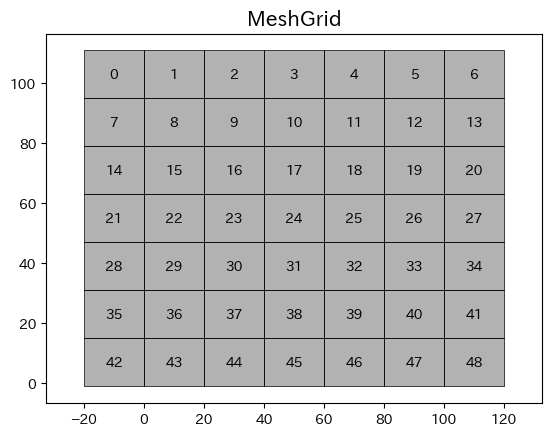

In [19]:
def generate_grid(x_2d: np.ndarray, y_2d: np.ndarray):
    X = corners(x_2d)
    Y = corners(y_2d)
    polys = []
    X_min = X.upper_left_corner
    X_max = X.upper_right_corner
    Y_min = Y.lower_left_corner
    Y_max = Y.upper_left_corner
    for coords in zip(X_min, Y_min, X_max, Y_max):
        poly = shapely.box(*coords)
        polys.append(poly)
    return polys


# MeshGridを構成する
meshgrid = generate_grid(x_2d, y_2d)

# 可視化
kwargs = dict(
    horizontalalignment='center',
    verticalalignment='center'
)
fig, ax = plt.subplots()
for i, poly in enumerate(meshgrid):
    plot_polygon(poly, ax, False, 'black', lw=0.5)
    pt = poly.centroid
    ax.text(pt.x, pt.y, i, **kwargs)
ax.set_title('MeshGrid', fontsize=15)
ax.axis('equal');

## **ID の作成**
ここまでで MeshGrid を構成する Polygon を作成する事が出来ました。しかしこのまま利用するよりも、せっかくなので各 Polygon にIDを付与して`geopandas.GeoDataFrame`に格納しましょう。

ID の作り方は色々あると思いますが、今回は簡単に Y 方向はアルファベット、X 方向は数値で表現します。順番は左上から右下に向かって ID が進むように計算を行いましょう。

In [20]:
def alphabet_list(lower: bool=False):
    """アルファベットの格納されているリストを作成する"""
    if lower:
        return [a for a in string.ascii_lowercase]
    return [a for a in string.ascii_uppercase]


def alphabet_ids(length: int, lower_case: bool=False) -> List[str]:
    """アルファベットIDのリストを生成"""
    alphabet = alphabet_list(lower_case)
    ids = []
    count = 0
    cols = 1
    while True:
        if count == length:
            # 生成したIDの数がlengthと同じ数値になれば終了する
            break
        if not alphabet:
            # アルファベットのListが空になったらまた作成する
            alphabet = alphabet_list(lower_case)
            cols += 1
        # Zを超える度に文字数を増やす
        id_ = alphabet.pop(0) * cols
        ids.append(id_)
        count += 1
    return ids


def generate_id(height: int, width: int, alphabet: bool=True) -> List[str]:
    """IDの生成を行う"""
    if alphabet:
        left = alphabet_ids(height)
    else:
        left = np.arange(0, height).astype(str)
    
    right = np.arange(0, width).astype(str)
    lefts, rights = np.meshgrid(left, right)
    ids = [f"{l}-{r}" for l, r in zip(lefts.T.flatten(), rights.T.flatten())]
    return ids

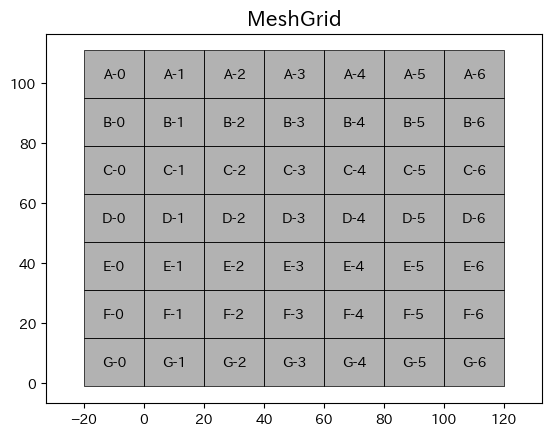

In [21]:
# IDの作成
ids = generate_id(*[v-1 for v in x_2d.shape])

# 可視化
kwargs = dict(
    horizontalalignment='center',
    verticalalignment='center'
)
fig, ax = plt.subplots()
for poly, id_ in zip(meshgrid, ids):
    plot_polygon(poly, ax, False, 'black', lw=0.5)
    pt = poly.centroid
    ax.text(pt.x, pt.y, id_, **kwargs)
ax.set_title('MeshGrid', fontsize=15)
ax.axis('equal');

## **GeoDataFrameへの入力**

In [10]:
gdf = gpd.GeoDataFrame(
    data={
        'idx': np.arange(0, len(meshgrid)),
        'ID': ids,
    },
    geometry=meshgrid
)

print(gdf.head(10).to_markdown())

|    |   idx | ID   | geometry                                                |
|---:|------:|:-----|:--------------------------------------------------------|
|  0 |     0 | A-0  | POLYGON ((0 110, 0 126, -20 126, -20 110, 0 110))       |
|  1 |     1 | A-1  | POLYGON ((20 110, 20 126, 0 126, 0 110, 20 110))        |
|  2 |     2 | A-2  | POLYGON ((40 110, 40 126, 20 126, 20 110, 40 110))      |
|  3 |     3 | A-3  | POLYGON ((60 110, 60 126, 40 126, 40 110, 60 110))      |
|  4 |     4 | A-4  | POLYGON ((80 110, 80 126, 60 126, 60 110, 80 110))      |
|  5 |     5 | A-5  | POLYGON ((100 110, 100 126, 80 126, 80 110, 100 110))   |
|  6 |     6 | A-6  | POLYGON ((120 110, 120 126, 100 126, 100 110, 120 110)) |
|  7 |     7 | B-0  | POLYGON ((0 94, 0 110, -20 110, -20 94, 0 94))          |
|  8 |     8 | B-1  | POLYGON ((20 94, 20 110, 0 110, 0 94, 20 94))           |
|  9 |     9 | B-2  | POLYGON ((40 94, 40 110, 20 110, 20 94, 40 94))         |
